In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
fire_dataframe = pd.read_csv('fires.csv')

# Handling of squished distributions

Show mean, variance, min, max and number of entries of the columns:

In [3]:
fire_dataframe.describe(include='all')

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517,517,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
unique,NaN,NaN,12,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,aug,sun,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,184,95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,4.669246,4.299807,NaN,NaN,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,NaN,NaN,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,NaN,NaN,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,NaN,NaN,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,NaN,NaN,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,NaN,NaN,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000


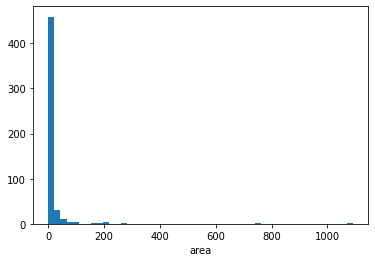

In [4]:
plt.hist(fire_dataframe['area'], bins = 50)
plt.xlabel('area')
plt.show()

We can see that there are outliers with a very huge area (over 1000 hectare) in the dataset. Generally, the column seems to be very imbalanced. Since the burned area seems fine in the context, we cannot exclude the outliers and therefore have to adapt the column to not let the model focus too much on the outliers. The data can be spread out more with help of the log function.

In [5]:
fire_dataframe['area'] = np.log(fire_dataframe['area']+1)

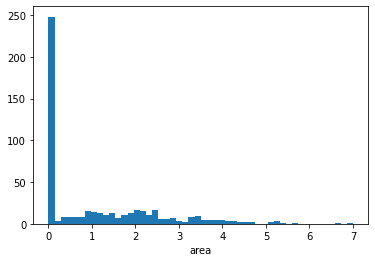

In [6]:
plt.hist(fire_dataframe['area'], bins = 50)
plt.xlabel('area')
plt.show()

Now the area is more evenly distributed.

In [7]:
print(fire_dataframe.mean(numeric_only=True))

X         4.669246
Y         4.299807
FFMC     90.644681
DMC     110.872340
DC      547.940039
ISI       9.021663
temp     18.889168
RH       44.288201
wind      4.017602
rain      0.021663
area      1.111026
dtype: float64


We also have to check on the other columns to see if there are irregularities we have to account for.

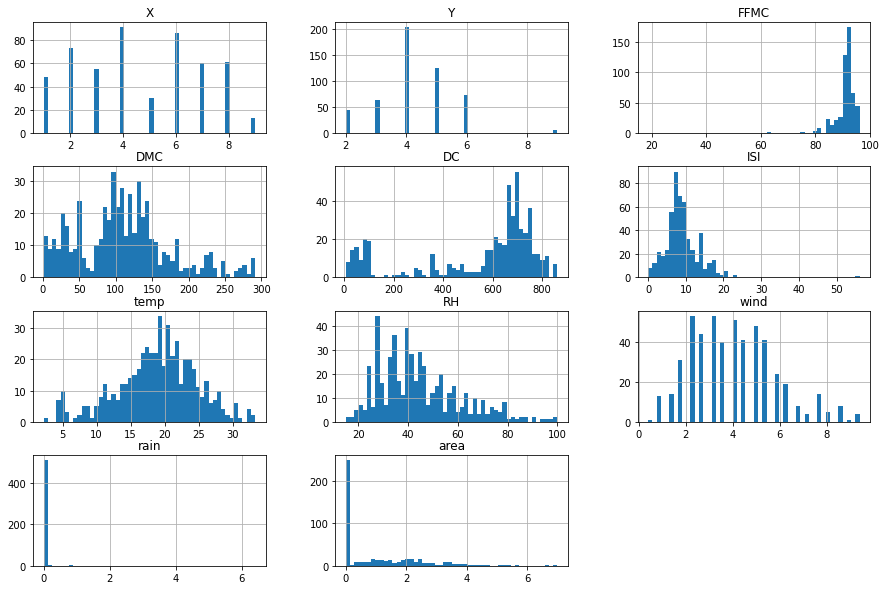

In [8]:
_ = fire_dataframe.hist(bins = 50, figsize=(15, 10))

Generally, it seems like the dataset is well balanced except for the ISI and the FFMC index. Since the ISI column can be left out (see handling correlations), only the FFMC index has to be changed. We can again use the log-function this time. We subtract from 100 since it is the maximal value FFMC can get according to https://cfs.nrcan.gc.ca/pubwarehouse/pdfs/19927.pdf.

In [9]:
fire_dataframe['FFMC'] = np.log(101-fire_dataframe['FFMC'])

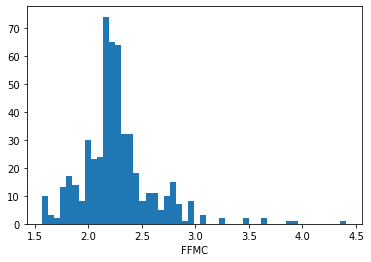

In [10]:
plt.hist(fire_dataframe['FFMC'], bins = 50)
plt.xlabel('FFMC')
plt.show()

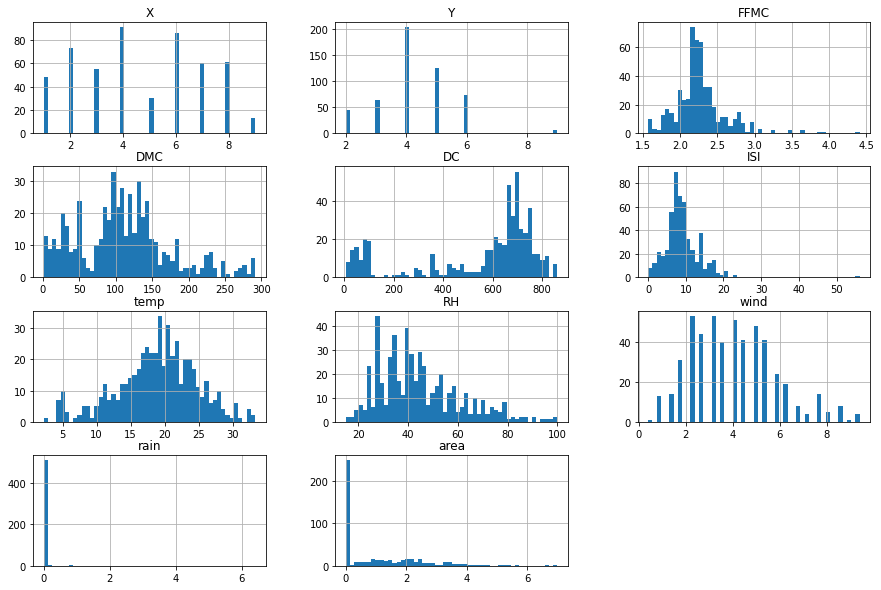

In [11]:
_ = fire_dataframe.hist(bins = 50, figsize=(15, 10))

# Handling correlations within the training data

One thing we want to avoid is having correlations within the data we use to predict our label. Columns that have a causal relationship do not bring new information to the model, while only making it more complex and therefore prone to overfitting. The easiest way to see if correlations (or even causalities) exist within our data is to look up how the indixes are calculated:

According to the "Development and Structure of the canadian Forest Fire Weather Index System" by van Wagner https://cfs.nrcan.gc.ca/pubwarehouse/pdfs/19927.pdf

$ISI = 0.208* e^{0.05039*wind}*f(FFMC)$, where f is a relativly complex function only depending on FFMC.


We can check this by calculating the correlation between the columns:

<AxesSubplot:>

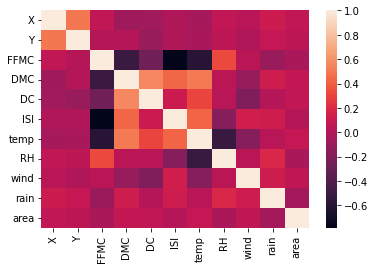

In [12]:
fire_corr = fire_dataframe.corr(method='spearman')
sns.heatmap(fire_corr, xticklabels=fire_corr.columns, yticklabels=fire_corr.columns)

In [13]:
print(fire_corr[(fire_corr>0.7) | (fire_corr<-0.7)])

        X    Y      FFMC  DMC   DC       ISI  temp   RH  wind  rain  area
X     1.0  NaN       NaN  NaN  NaN       NaN   NaN  NaN   NaN   NaN   NaN
Y     NaN  1.0       NaN  NaN  NaN       NaN   NaN  NaN   NaN   NaN   NaN
FFMC  NaN  NaN  1.000000  NaN  NaN -0.783566   NaN  NaN   NaN   NaN   NaN
DMC   NaN  NaN       NaN  1.0  NaN       NaN   NaN  NaN   NaN   NaN   NaN
DC    NaN  NaN       NaN  NaN  1.0       NaN   NaN  NaN   NaN   NaN   NaN
ISI   NaN  NaN -0.783566  NaN  NaN  1.000000   NaN  NaN   NaN   NaN   NaN
temp  NaN  NaN       NaN  NaN  NaN       NaN   1.0  NaN   NaN   NaN   NaN
RH    NaN  NaN       NaN  NaN  NaN       NaN   NaN  1.0   NaN   NaN   NaN
wind  NaN  NaN       NaN  NaN  NaN       NaN   NaN  NaN   1.0   NaN   NaN
rain  NaN  NaN       NaN  NaN  NaN       NaN   NaN  NaN   NaN   1.0   NaN
area  NaN  NaN       NaN  NaN  NaN       NaN   NaN  NaN   NaN   NaN   1.0


We can see that there exists a high correlation between FFMC and ISI. We know that ISI is dependent on FFMC and wind, which is why we are going to exclude this column from our model building.

In [14]:
fire_dataframe.drop('ISI', axis=1,  inplace=True)

# Transform month and day to numerical values

We can see that there is no clear distinction between weekend and weekday. Therefore transforming 'day' into a boolean value regarding weekend is not enough.

In [15]:
fire_dataframe.groupby('day').mean()['area']

day
fri    0.969771
mon    1.089968
sat    1.226396
sun    1.124093
thu    1.026267
tue    1.230719
wed    1.113664
Name: area, dtype: float64

Replacing the month values by a boolean regarding summer and winter also seems to be fruitless.

In [16]:
fire_dataframe.groupby('month').mean()['area']

month
apr    1.089224
aug    1.045196
dec    2.571670
feb    1.087834
jan    0.000000
jul    1.083641
jun    0.843091
mar    0.772565
may    1.837897
nov    0.000000
oct    0.917051
sep    1.274537
Name: area, dtype: float64

Transforming month and weekday into numerical values can neither be done via one-hot-encoding nor by simply transforming it into the numbers 0-6 and 0-11. One-hot-encoding removes the order of days while number transformation is also wrong, since Sunday is closer to Monday than Wednesday. The solution to encode the circular relationship of weekdays and months is to transform both into sin and cosine values.

In [17]:
mapping_day = {'mon':0, 'tue':1, 'wed':2, 'thu':3, 'fri':4, 'sat':5, 'sun':6}
mapping_month = {'jan':0, 'feb':1, 'mar':2, 'apr':3, 'may':4, 'jun':5, 'jul':6, 'aug':7, 'sep':8, 'oct':9, 'nov':10, 'dec':11}
fire_dataframe.replace({'day': mapping_day, 'month': mapping_month}, inplace=True)
fire_dataframe['day_sin'] = np.sin(fire_dataframe['day'] * (2 * np.pi / 7))
fire_dataframe['day_cos'] = np.cos(fire_dataframe['day'] * (2 * np.pi / 7))
fire_dataframe['month_sin'] = np.sin(fire_dataframe['month'] * (2 * np.pi / 12))
fire_dataframe['month_cos'] = np.cos(fire_dataframe['month'] * (2 * np.pi / 12))
fire_dataframe.drop(['day', 'month'], axis=1, inplace=True)

In [18]:
fire_dataframe.head(10)

,X,Y,FFMC,DMC,DC,temp,RH,wind,rain,area,day_sin,day_cos,month_sin,month_cos
0,7,5,2.694627,26.2,94.3,8.2,51,6.7,0.0,0.0,-0.433884,-0.900969,0.866025,5.000000e-01
1,7,4,2.341806,35.4,669.1,18.0,33,0.9,0.0,0.0,0.781831,0.623490,-1.000000,-1.836970e-16
2,7,4,2.341806,43.7,686.9,14.6,33,1.3,0.0,0.0,-0.974928,-0.222521,-1.000000,-1.836970e-16
3,8,6,2.230014,33.3,77.5,8.3,97,4.0,0.2,0.0,-0.433884,-0.900969,0.866025,5.000000e-01
4,8,6,2.459589,51.3,102.2,11.4,99,1.8,0.0,0.0,-0.781831,0.623490,0.866025,5.000000e-01
5,8,6,2.163323,85.3,488.0,22.2,29,5.4,0.0,0.0,-0.781831,0.623490,-0.500000,-8.660254e-01
6,8,6,2.163323,88.9,495.6,24.1,27,3.1,0.0,0.0,0.000000,1.000000,-0.500000,-8.660254e-01
7,8,6,2.251292,145.4,608.2,8.0,86,2.2,0.0,0.0,0.000000,1.000000,-0.500000,-8.660254e-01
8,8,6,2.302585,129.5,692.6,13.1,63,5.4,0.0,0.0,0.781831,0.623490,-0.866025,-5.000000e-01
9,7,5,2.140066,88.0,698.6,22.8,40,4.0,0.0,0.0,-0.974928,-0.222521,-0.866025,-5.000000e-01


# Splitting the data into train_test and validation

We split the data into 90% train_test and 10% validation.

In [19]:
y = fire_dataframe['area'].to_numpy()
X = fire_dataframe.drop('area', axis = 1).to_numpy()

In [20]:
X_train_test, X_val, y_train_test, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

# Creating the model with k-fold cross-validation

Since linear regression only has lambda as hyperparameter, we need to only focus on iproving this. To find the optimal lambda, we test the prediction power of the model with a lambda from 0 to 10 with a step-size of 1. We use mean absolute loss as test-metric.

In [21]:
def train_linear_reg(X, y, lmbd):
    return np.linalg.inv(np.transpose(X).dot(X) + lmbd*np.eye(len(X[0]))).dot(np.transpose(X)).dot(y)

In [22]:
def normalize(dataset, mean, variance):
    return (dataset-mean)/variance

In [23]:
train_loss_per_lambda = []
test_loss_per_lambda = []
for reg_lambda in range(11):
    kf = KFold(n_splits=10)
    prediction_loss = []
    train_loss = []
    for train_index, test_index in kf.split(X_train_test):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        #apply z normalization to X
        train_variance = np.var(X_train, axis=0)
        train_mean = np.mean(X_train, axis=0)
        X_train = normalize(X_train, train_mean, train_variance)
        X_test = normalize(X_test, train_mean, train_variance)
        theta = train_linear_reg(X_train, y_train, reg_lambda)
        test_prediction = X_test.dot(theta)
        train_prediction = X_train.dot(theta)
        prediction_loss.append(mean_squared_error(y_test, test_prediction))
        train_loss.append(mean_squared_error(y_train, train_prediction))
    train_loss_per_lambda.append(np.mean(train_loss))
    test_loss_per_lambda.append(np.mean(prediction_loss))

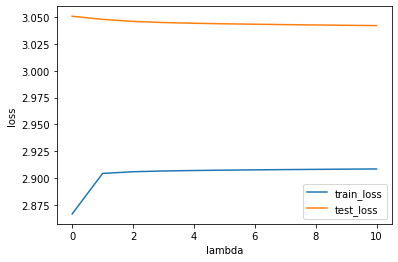

In [24]:
plt.plot(train_loss_per_lambda, label='train_loss')
plt.plot(test_loss_per_lambda, label = 'test_loss')
plt.xlabel('lambda')
plt.ylabel('loss')
plt.legend()
plt.show()

It seems like a lambda of 0 is the best hyperparameter.

Now we can train on train and test data to evaluate the model on the validataion data. We use the mean absolute error to get an understandable metric. To understand how big the error really is, we also have to reverse the log-scale.

In [25]:
train_test_mean = np.mean(X_train_test, axis=0)
train_test_var = np.mean(X_train_test, axis=0)
X_train_test_normalized = normalize(X_train_test, train_test_mean, train_test_var)
X_val_normalized = normalize(X_val, train_test_mean, train_test_var)
theta = train_linear_reg(X_train_test_normalized, y_train_test, 6)
val_prediction = X_val_normalized.dot(theta)
mae = mean_absolute_error(np.exp(y_val)-1, np.exp(val_prediction)-1)
print(mae)

27.109888660407474


On average, the model has an error of around 27 hectare.

We can compare this model with a trivial model. Since most of the y-values seem to be 0, our trivial model only predicts 0 as burnt area.

In [26]:
mae_trivial = mean_absolute_error(np.exp(y_val)-1, [0 for x in range(len(y_val))])
print(mae_trivial)

27.05711538461539


It seems that the trivial model is better at predicting the burned area than the Linear regressor. A reason for this can be the low correlation between the area and the other columns in the dataframe.

In [27]:
print(fire_corr['area'])

X       0.060499
Y       0.046018
FFMC   -0.025300
DMC     0.071920
DC      0.061633
ISI     0.012496
temp    0.078696
RH     -0.024221
wind    0.053196
rain   -0.064073
area    1.000000
Name: area, dtype: float64
